In [1]:
import os
import copy
import sys 

# Regular Modules
import numpy as np
import sklearn as sklearn
import matplotlib.pyplot as plt
import datetime
import scipy.integrate as scint
#from numpy.random import default_rng
import numpy.ma as ma
import matplotlib.tri as tri
import scipy.io
import time 
from mpl_toolkits.mplot3d import axes3d

# parallelization modules 
from math import nan
from joblib import Parallel, delayed
import multiprocess
import itertools
import tqdm

# # My Modules
import model_systems, helpers, potentials, diffusion_map 
from fem.distmesh import * 
from fem.FEM_TPT import *
import sampling 

# Set up the problem 

In [2]:
# first choose problem 
problem = "muller"
datadir = "/Users/shashanksule/Documents/TMDmaps/data/Muller/ground_data/DistmeshMuller_20.mat"
if problem == "muller":
    system = potentials.Muller(1/20, datadir) 
elif problem == "twowell":
    system = potentials.Twowell(1, datadir)
else:
    print("invalid problem")
savedir = "/Users/shashanksule/Documents/TMDmaps/data/Muller/error_data/"

In [4]:
# next choose dataset params 

dataset = "gibbs"
x0 = np.array([0,0])
dt = 1e-4
Vbdry = 10 # 10 for muller, 1 (or less for twowell)

# metadynamics params here
Nbumps = int(1e2) 
Ndeposit = int(1e3)
subsample = int(1e1)
height = 5*np.ones(Nbumps)
sig = 0.05 

In [5]:
# compute dataset 

if dataset == "gibbs": 
    data = sampling.euler_maruyama_OLD(system.drift, system.target_beta, \
                                       dt, x0, \
                                       int(1e6), int(1e2))
elif dataset == "metadynamics":
    data = sampling.euler_maruyama_metadynamics_OLD(system.drift, system.target_beta, \
                                                    dt, x0, height, sig, \
                                                    Ndeposit, Nbumps, subsample)
elif dataset == "uniform": 
    data = sampling.fem_pts(system, 0.05, Vbdry)

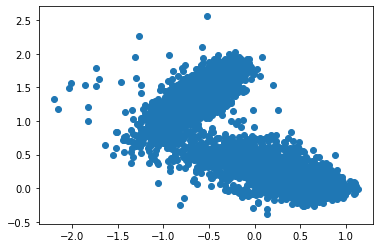

In [7]:
# visualize dataset 

plt.scatter(data[:,0], data[:,1])

In [8]:
# upload fem soltuon
system.load_fem()

print("System has been set up!")

System has been set up!


In [33]:
if problem == "muller":
    system.plant_point = np.array([0.25,0.0])

# Run error sweep for one parameter combination 

In [120]:
def error_data(t, \
               pw_error=False, count_points = False, kernel_stats = False, \
               verbose = False, error_stats = True): 
    
    ϵ, data_uniformized, vbdry, n_neigh = t # unravel parameters 
    
    if verbose:
         print("Started!")
    
    if pw_error:
        data_uniformized = np.vstack((data_uniformized, system.plant_point))
    
    err_boolz = system.throwing_pts_muller(data_uniformized.T, vbdry) # get points on data for error calculation
    fem_error_boolz = system.throwing_pts_muller(system.qfem['pts'].T, vbdry) # get points on fem mesh for error calc.
    
    N = data_uniformized.shape[0] # get # of data points 
    outputs = []
    
    # collect # of points 
    if count_points: 
        outputs.append(N)
    
    # check knn condition 
    if n_neigh > N: 
        n_neigh = N-1
    
    # compute t.m.
    target_measure = np.zeros(N)
    for i in range(N):
        target_measure[i] = system.density(data_uniformized[i,:])
        
    # get tmdmap 
    target_dmap = diffusion_map.TargetMeasureDiffusionMap(epsilon=ϵ, n_neigh=n_neigh, \
                                                          target_measure=target_measure)
    
    # get kernel and generator
    target_dmap.construct_generator(data_uniformized.T)
    K = target_dmap.get_kernel()
    L = target_dmap.get_generator() 
     
    if pw_error: 
        # interpolate the true solution 
        q_interpolant_fem_to_tmd = scipy.interpolate.griddata(system.qfem['pts'], system.qfem['committor'],\
                                                              data_uniformized, method='linear')
        # compute L_epsilon,mu * q(x)
        Lf = L@q_interpolant_fem_to_tmd
        
        # attach to output array
        if verbose:
            print("Computed pw error!")

        outputs.append(np.abs(Lf[-1]))
        
    if kernel_stats:
        
        # singer's estimate 
        outputs.append(scipy.sparse.csr_matrix.mean(K))
     
    if error_stats: 
        
        # solve committor problem
        try:
            q_tmd = target_dmap.construct_committor(L, err_boolz['B_bool'], err_boolz['C_bool'])
        except BaseException as e:
            print(e)
            outputs.append(1e10)
        else:
            if verbose:
                 print("hard part--done!")

            # checking interpolation, run this only if you want
            q_interpolant_fem_to_tmd = scipy.interpolate.griddata(system.qfem['pts'], system.qfem['committor'],\
                                                                  data_uniformized, method='linear')
            q_interpolant_tmd_to_fem = scipy.interpolate.griddata(data_uniformized, q_tmd, system.qfem['pts'], \
                                                          method='linear')

            # compute errors on fem points 
            q_fem_error = system.qfem['committor'][fem_error_boolz['error_bool']]
            q_interpolant_tmd_to_fem_error = q_interpolant_tmd_to_fem[fem_error_boolz['error_bool']].reshape(q_fem_error.shape)

            # compute errors on tmd points 
            q_tmd_error = q_tmd[err_boolz['error_bool']]
            q_interpolant_fem_to_tmd_error = q_interpolant_fem_to_tmd[err_boolz['error_bool']].reshape(q_tmd_error.shape)
            
            if verbose:
                 print("Done!")
            
            outputs.append(helpers.RMSerror(q_tmd_error, q_interpolant_fem_to_tmd_error, checknans=False))
        
    return outputs 

# Playing with multiprocessing/data collection

In [10]:
# set up sparsification modules 

def deltanet(delta):
    δ_net, _ = helpers.epsilon_net(data.T, delta)
    return data[δ_net, :]
def uniformnet(scaling):
    return sampling.fem_pts(system, scaling, Vbdry)

In [11]:
# set up post-processed datasets 

num = multiprocess.cpu_count()
# deltas = list(np.linspace(1e-6, 1e-1, 10))
deltas = [0.02, 0.04]
if dataset == "uniform":
    with multiprocess.Pool(num) as processing_pool:
        datasets = processing_pool.map(uniformnet, deltas)
else:
    with multiprocess.Pool(num) as processing_pool:
        datasets = processing_pool.map(deltanet, deltas)

In [12]:
# set up all the other parameters of the system 
epsilons = [2**(-5), 2**(-6)]
# epsilons = list(2.0**np.arange(-16, 2, 0.25))
vbdry = [10,-10]
n_neigh = [1024]
args = list(itertools.product(*[epsilons, datasets, vbdry, n_neigh])) # create iterable for multiprocess
params = {"epsilons": epsilons, "deltas": deltas, "vbry": vbdry, "n_neigh": n_neigh}

print("parameters are ready! Beginning error analysis...")

parameters are ready! Beginning error analysis...


# Diagnostics

In [57]:
# run error analysis: this order is VERY important! 
count_points = True
pw_error = True
kernel_stats = True
error_stats = True

# stats for algorithm 
verbose = True
parallel = False


ϵ, data_uniformized, vbdry, n_neigh = args[0] # unravel parameters 

In [68]:
if verbose:
     print("Started!")

if pw_error:
    data_uniformized = np.vstack((data_uniformized, system.plant_point))

err_boolz = system.throwing_pts_muller(data_uniformized.T, vbdry) # get points on data for error calculation
fem_error_boolz = system.throwing_pts_muller(system.qfem['pts'].T, vbdry) # get points on fem mesh for error calc.

N = data_uniformized.shape[0] # get # of data points 
outputs = []

# collect # of points 
if count_points: 
    outputs.append(N)

# check knn condition 
if n_neigh > N: 
    n_neigh = N-1

# compute t.m.
target_measure = np.zeros(N)
for i in range(N):
    target_measure[i] = system.density(data_uniformized[i,:])

# get tmdmap 
target_dmap = diffusion_map.TargetMeasureDiffusionMap(epsilon=ϵ, n_neigh=n_neigh, \
                                                      target_measure=target_measure)

# get kernel and generator
target_dmap.construct_generator(data_uniformized.T)
K = target_dmap.get_kernel()
L = target_dmap.get_generator() 

if pw_error: 
    # interpolate the true solution 
    q_interpolant_fem_to_tmd = scipy.interpolate.griddata(system.qfem['pts'], system.qfem['committor'],\
                                                          data_uniformized, method='linear')
    # compute L_epsilon,mu * q(x)
    inds_bool = np.isnan(q_interpolant_fem_to_tmd)
    
    # flash error message if the interpolation fails 
    if inds_bool[-1]:
        if verbose:
            print("failed to interpolate to plant point")
        outputs.append(nan)
    else:
        LL = L[np.where(~inds_bool)[0],:][:,np.where(~inds_bool)[0]]
        qq = q_interpolant_fem_to_tmd[np.where(~inds_bool)]
        Lf = L@q_interpolant_fem_to_tmd
        outputs.append(Lf[-1][0])

Started!


# Error analysis

In [124]:
# run error analysis: this order is VERY important! 
count_points = True
pw_error = True
kernel_stats = True
error_stats = True

# stats for algorithm 
verbose = True
parallel = False

def onepass(t): return error_data(t,pw_error,count_points,kernel_stats, verbose, error_stats)

if parallel: 
    with multiprocess.Pool(num) as pool:
        result = pool.map(onepass, args)
else:
    result = []
    for i in tqdm.tqdm(range(len(args))):
        ans = onepass(args[i])
        result.append(ans)

  0%|                                                     | 0/8 [00:00<?, ?it/s]

Started!
Computed pw error!
hard part--done!


 12%|█████▋                                       | 1/8 [00:01<00:09,  1.41s/it]

Done!
Started!
Computed pw error!
hard part--done!


 25%|███████████▎                                 | 2/8 [00:02<00:07,  1.31s/it]

Done!
Started!
Computed pw error!
hard part--done!


 38%|████████████████▉                            | 3/8 [00:03<00:05,  1.20s/it]

Done!
Started!
Computed pw error!
hard part--done!


 50%|██████████████████████▌                      | 4/8 [00:04<00:04,  1.15s/it]

Done!
Started!
Computed pw error!
hard part--done!


 62%|████████████████████████████▏                | 5/8 [00:05<00:03,  1.17s/it]

Done!
Started!
Computed pw error!
hard part--done!


 75%|█████████████████████████████████▊           | 6/8 [00:07<00:02,  1.18s/it]

Done!
Started!
Computed pw error!
hard part--done!


 88%|███████████████████████████████████████▍     | 7/8 [00:08<00:01,  1.14s/it]

Done!
Started!
Computed pw error!
hard part--done!


100%|█████████████████████████████████████████████| 8/8 [00:09<00:00,  1.16s/it]

Done!


In [129]:
# process data 
stats = [count_points, pw_error, kernel_stats, error_stats]
stat_names = np.array(["N_points", "PW_error", "singer_estimates", "error_tensor"], dtype=str)
stat_names = stat_names[stats]
sim_results = {}
for names in stat_names:
    sim_results[names] = []
for j in range(len(result)):
    for i in range (len(sim_results.items())):
        sim_results[stat_names[i]].append(result[j][i])
for name,_ in sim_results.items():
    sim_results[name] = np.array(sim_results[name]).reshape(len(epsilons), len(deltas), len(vbdry), len(n_neigh))

In [131]:
# write to file 
stats = {"system": problem, "beta": system.target_beta, "args": params, "sim_results": sim_results}
filename = savedir + problem + "_" + dataset + ".npy"
np.save(filename, stats)

In [ ]:
# # to load 
# stats_loaded = np.load(filename, allow_pickle = True).item()